<a href="https://colab.research.google.com/github/And-Bado/ECE-4050/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[What is EEG and time-frequency analysis?](https://youtu.be/FIqvTUOGFOE?si=5hFMbAp3RpghlKoM)



[How to make predictions based on EEG?](https://youtu.be/SKIaW5YvF6Y?si=R5AlNCTIsh3AjNkn)

In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import scipy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import scipy.signal as ss

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Welcome
This notebook will walk you through how to analyse brain wave data. This data was collected in the Neural Engineering Laboratory at the University of Missouri - Columbia.

In [45]:
# clone github repo with the data
!git clone https://github.com/davidfague/4540_NM_ML.git

fatal: destination path '4540_NM_ML' already exists and is not an empty directory.


In [46]:
# read the data into pandas dataframe
df = pd.read_csv('4540_NM_ML/Project 1/OpenBCI-RAW-2020-03-10_08-53-44.txt',skiprows=6,header=None)

In [47]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0,-76.20,1.38,-34.35,-51.09,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
1,1,-36.12,29.01,76.34,48.51,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
2,2,-43.59,31.42,58.11,30.55,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
3,3,-77.29,2.68,-19.45,-49.45,0.912,0.112,-0.464,08:54:30.274,1.583848e+12
4,4,-57.05,17.48,52.08,23.03,0.912,0.112,-0.464,08:54:30.274,1.583848e+12


In [48]:
df.columns=['index','channel1','channel2','channel3','channel4','acc1','acc2','acc3','time_std','timestamp']
df.drop(['index'],axis=1,inplace=True)

In [49]:
df.head()

,channel1,channel2,channel3,channel4,acc1,acc2,acc3,time_std,timestamp
0,-76.20,1.38,-34.35,-51.09,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
1,-36.12,29.01,76.34,48.51,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
2,-43.59,31.42,58.11,30.55,0.912,0.112,-0.464,08:54:30.263,1.583848e+12
3,-77.29,2.68,-19.45,-49.45,0.912,0.112,-0.464,08:54:30.274,1.583848e+12
4,-57.05,17.48,52.08,23.03,0.912,0.112,-0.464,08:54:30.274,1.583848e+12


# Explanation of the data
As you can see the dataframe consists of 8 columns. Each row is a sample. The data was sampled at 200 Hz. That means 200 samples per second. There are four channels on the EEG device, two of these were place on the frontal lobe (forehead) and two on the temporal lobe (sides of the head). The acc1-3 channels are the accelerometer. If the subject moves, these channels will detect that. The time is represented by the final two columns.

Below, we will plot the entire time course of one channel.

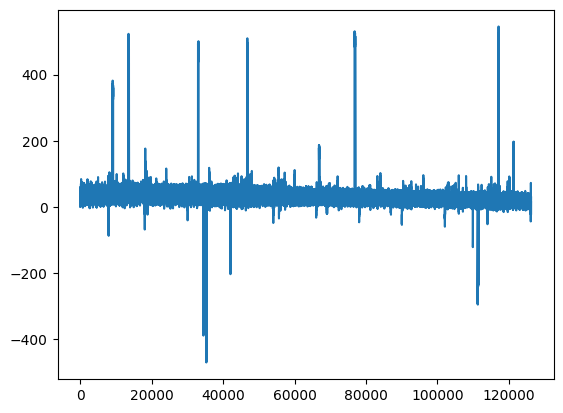

In [50]:
plt.figure()
plt.plot(df['channel2'])

Question 1. What should the axes be labeled on the plot above?

Answer: The X-axis should be labled Time and the Y-axis should be labled channel2 (Voltage Potential).

# Remove drift
The mean of the data changes over time. This is called drift. We can remove this trend in the data using scipy's detrend function.

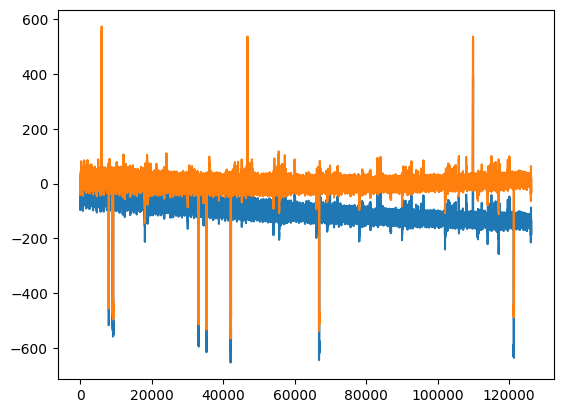

In [51]:
plt.plot(df['channel1'])
plt.plot(ss.detrend(df['channel1']))

In [52]:
df['channel1'] = ss.detrend(df['channel1'])
df['channel2'] = ss.detrend(df['channel2'])
df['channel3'] = ss.detrend(df['channel3'])
df['channel4'] = ss.detrend(df['channel4'])

Question 2. Where does drift come from?

Answer: The drift come from accruing electrical potentials in the skin that slowly dirstort EEG data as it is collected. Because it is always present it forms a realitivly steady change over time.

# Artifact removal
Whenever the subject moved or blinked, there is a large deviation in the potential of all channels. We need to remove these.

In [53]:
zchan1 = (df['channel1']-np.mean(df['channel1']))/np.std(df['channel1'])
zchan2 = (df['channel2']-np.mean(df['channel2']))/np.std(df['channel2'])
zchan3 = (df['channel3']-np.mean(df['channel3']))/np.std(df['channel3'])
zchan4 = (df['channel4']-np.mean(df['channel4']))/np.std(df['channel4'])

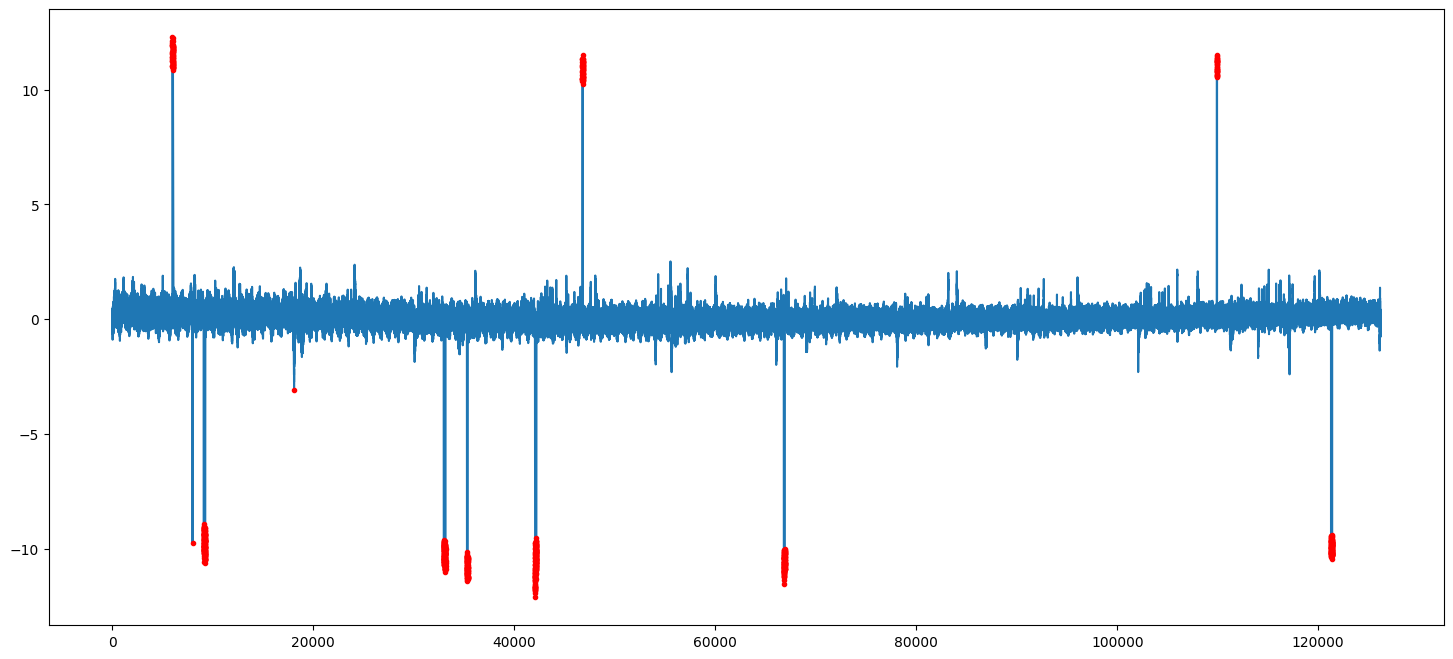

In [54]:
plt.figure(figsize=(18,8))
plt.plot(zchan1)
plt.plot(zchan1[np.abs(zchan1)>3],'r.')

Most of these are artifacts.

Question 3. What is one source of artifacts?

Answer: Because electrical potentials are bing picked up from various parts of the brain any movements or other stimulus is shown as a sharp change in the othewise stable data. They are very short, but intense, bursts of electrical potential changes.

# Make y labels
The subject was in two states during the experiment; their eyes were either open or closed. Below, we define the times at which the eyes were open or closed.

In [55]:
df['seconds_from_start']=(df['timestamp']-df['timestamp'].iloc[0])/1000

In [56]:
y_labels = np.zeros((df['time_std'].shape[0],1))

In [57]:
y_labels[(60<df.seconds_from_start)&(df.seconds_from_start<90)] = 1
y_labels[(120<df.seconds_from_start)&(df.seconds_from_start<150)] = 1
y_labels[(180<df.seconds_from_start)&(df.seconds_from_start<210)] = 1
y_labels[(240<df.seconds_from_start)&(df.seconds_from_start<270)] = 1
y_labels[(300<df.seconds_from_start)&(df.seconds_from_start<330)] = 1
y_labels[(360<df.seconds_from_start)&(df.seconds_from_start<390)] = 1
y_labels[(420<df.seconds_from_start)&(df.seconds_from_start<450)] = 1
y_labels[(480<df.seconds_from_start)&(df.seconds_from_start<510)] = 1
y_labels[(540<df.seconds_from_start)&(df.seconds_from_start<570)] = 1
y_labels[(600<df.seconds_from_start)&(df.seconds_from_start<630)] = 1

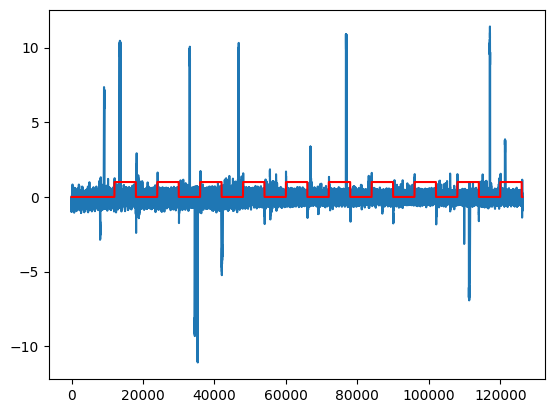

In [58]:
plt.plot(zchan2)
plt.plot(y_labels,'r')

In the plot above, the trace of a single channel is shown in blue and whether or not the eyes were closed is shown in red. y_labels == 1 means eyes closed and y_labels == 0 means eyes open.

Remove 60 Hz noise and artifacts. Any time a signal is recorded inside of a building, there will be a prominent 60 Hz noise from the power lines. We will remove this using a notch filter.

Question 4. What are the 'groundtruth' classifications for this data? Where do they come from?

Answer: The 'groundtruth' classifiations are eyes open or closed, this is known becaue the subject was recored opening and closing their eyes for repeated ten second intervals.

In [59]:
b, a = ss.iirnotch(60.0, 200.0, 200.)

zchan1 = ss.filtfilt(b,a,zchan1)
zchan2 = ss.filtfilt(b,a,zchan2)
zchan3 = ss.filtfilt(b,a,zchan3)
zchan4 = ss.filtfilt(b,a,zchan4)

zchan1[np.abs(zchan1)>3] = np.nan
zchan2[np.abs(zchan2)>3] = np.nan
zchan3[np.abs(zchan3)>3] = np.nan
zchan4[np.abs(zchan4)>3] = np.nan
y_labels[(np.abs(zchan1)>3) | (np.abs(zchan2)>3) | (np.abs(zchan3)>3) | (np.abs(zchan4)>3)] = np.nan

In [60]:
df['channel1'] = zchan1
df['channel2'] = zchan2
df['channel3'] = zchan3
df['channel4'] = zchan4
df['y_labels'] = y_labels

The below graph shows the difference between eyes closed and eyes open in the frequency domain. It is well known that the eyes closed condition generates alpha waves at 8-12 Hz, which we also see in this recording. There may still be some 60 Hz noise that our notch filter failed to remove.

<ipython-input-61-4c315fd989c0>:2: MatplotlibDeprecationWarning: Passing the NFFT parameter of psd() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.psd(X[~np.isnan(X)],512,Fs=200,color='r')
<ipython-input-61-4c315fd989c0>:4: MatplotlibDeprecationWarning: Passing the NFFT parameter of psd() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.psd(X[~np.isnan(X)],512,Fs=200)


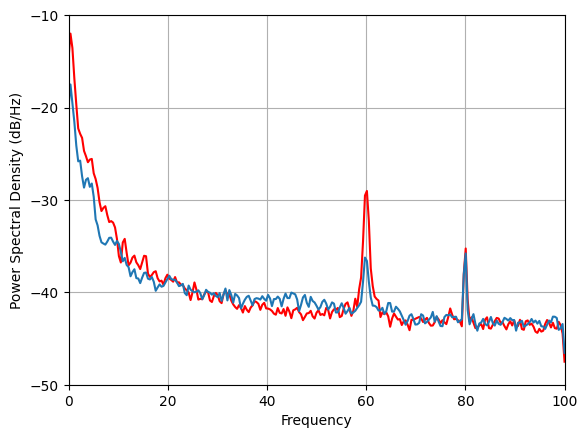

In [61]:
X = df['channel2'].iloc[y_labels[:,0]==0]
plt.psd(X[~np.isnan(X)],512,Fs=200,color='r')
X = df['channel2'].iloc[y_labels[:,0]==1]
plt.psd(X[~np.isnan(X)],512,Fs=200)
plt.xlim(0,100)
#plt.show()
plt.show()

Question 5. What 'noise' causes the peak at 60 Hz frequency? What about 80 Hz? Will there be peaks at multiples of these frequencies i.e. 120 Hz? What is the name of the structure that neuroscience researchers perform electrophysiology inside to eliminate such noise?

Answer:

The 60Hz interferance is the continued background power/device related interferance, as electrical systems run on 60Hz.

The 80Hz is from high frequency brain activity, when opening or closing your eyes mental processes are going on that are represented as a 80Hz spike, even if the activity itself is a low Hz signal. EEG monitors multiple parts of your brain, rather than the jutting spike from movement, this is a regular spike from thinking really fast, or image processing.

The tool to reduce noise used is called a faraday cage, which helps limit external interferance signals.

In [64]:
# Install scipy (only needed once, can be skipped if already installed)
# !pip install --upgrade scipy

# === Imports ===
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.signal import welch

# === Bandpower Function ===
def bandpower(trace, band, fs=200):
    trace = trace[~np.isnan(trace)]
    # Check if trace has enough data points
    if len(trace) < 2: # Add a check to ensure enough data points are available
        return np.nan

    f, Pxx = welch(trace, fs=fs, nperseg=512)
    # Use 'scipy.integrate.simpson' for integration
    total_power = integrate.simpson(Pxx, f)
    band_mask = (f > band[0]) & (f < band[1])
    # Check if band_mask is empty
    if not band_mask.any(): # Add a check for an empty band_mask
        return np.nan

    # Use 'scipy.integrate.simpson' for integration
    band_power = integrate.simpson(Pxx[band_mask], f[band_mask])
    return band_power / total_power if total_power != 0 else np.nan

# === Feature Extraction ===
input_mat = np.zeros((600, 21))
c = 0

for i in np.arange(0, 120000, 200):
    X1 = df['channel1']
    X2 = df['channel2']
    X3 = df['channel3']
    X4 = df['channel4']
    Y = df['y_labels']

    X1 = X1[i:i+200]
    X2 = X2[i:i+200]
    X3 = X3[i:i+200]
    X4 = X4[i:i+200]
    Y = Y[i:i+200]

    # Alpha band (8–12 Hz)
    input_mat[c, 0] = bandpower(X1, [8, 12])
    input_mat[c, 1] = bandpower(X2, [8, 12])
    input_mat[c, 2] = bandpower(X3, [8, 12])
    input_mat[c, 3] = bandpower(X4, [8, 12])

    # Theta band (3–8 Hz)
    input_mat[c, 4] = bandpower(X1, [3, 8])
    input_mat[c, 5] = bandpower(X2, [3, 8])
    input_mat[c, 6] = bandpower(X3, [3, 8])
    input_mat[c, 7] = bandpower(X4, [3, 8])

    # Beta band (12–38 Hz)
    input_mat[c, 8] = bandpower(X1, [12, 38])
    input_mat[c, 9] = bandpower(X2, [12, 38])
    input_mat[c, 10] = bandpower(X3, [12, 38])
    input_mat[c, 11] = bandpower(X4, [12, 38])

    # Gamma band (38–100 Hz)
    input_mat[c, 12] = bandpower(X1, [38, 100])
    input_mat[c, 13] = bandpower(X2, [38, 100])
    input_mat[c, 14] = bandpower(X3, [38, 100])
    input_mat[c, 15] = bandpower(X4, [38, 100])

    # Delta band (0.5–3 Hz)
    input_mat[c, 16] = bandpower(X1, [0.5, 3])
    input_mat[c, 17] = bandpower(X2, [0.5, 3])
    input_mat[c, 18] = bandpower(X3, [0.5, 3])
    input_mat[c, 19] = bandpower(X4, [0.5, 3])

    # Label: Eyes closed
    u, n = np.unique(Y, return_counts=True)
    input_mat[c, -1] = u[0].astype(int) if n.shape[0] == 1 else np.nan

    c += 1

# === Convert to DataFrame ===
feat_eng_df = pd.DataFrame(input_mat, columns=[
    'alpha_power_1','alpha_power_2','alpha_power_3','alpha_power_4',
    'theta_power_1','theta_power_2','theta_power_3','theta_power_4',
    'beta_power_1','beta_power_2','beta_power_3','beta_power_4',
    'gamma_power_1','gamma_power_2','gamma_power_3','gamma_power_4',
    'delta_power_1','delta_power_2','delta_power_3','delta_power_4',
    'eyes_closed'
])


/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 512 is greater than input length  = 200, using nperseg = 200
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 512 is greater than input length  = 167, using nperseg = 167
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 512 is greater than input length  = 170, using nperseg = 170
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 512 is greater than input length  = 199, using nperseg = 199
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWa

<Axes: xlabel='eyes_closed', ylabel='alpha_power_3'>

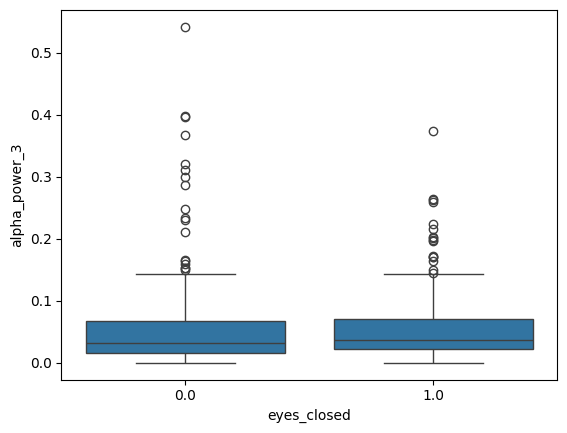

In [65]:
import seaborn as sns
sns.boxplot(x='eyes_closed',y='alpha_power_3',data=feat_eng_df)

# Feature Engineering Model

In [72]:
from sklearn.preprocessing import scale

train_df = feat_eng_df.iloc[0:420,:]
test_df = feat_eng_df.iloc[420:,:]

train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

X_train = X_train[~np.isnan(y_train)]
y_train = y_train[~np.isnan(y_train)]
X_test = X_test[~np.isnan(y_test)]
y_test = y_test[~np.isnan(y_test)]


X_train = scale(X_train)
X_test = scale(X_test)

In [73]:
X_train.shape, X_test.shape

((408, 20), (174, 20))

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer

# Initialize the imputer to replace NaN with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Handle missing values by imputing them with the mean of each feature
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize models
lr = LogisticRegression(random_state=231)
rf = RandomForestClassifier(random_state=2124)
mlp = MLPClassifier(hidden_layer_sizes=(5,), early_stopping=True, max_iter=1000, random_state=12)

# Train models on the training data and their measured classifications
lr.fit(X_train_imputed, y_train.values)
rf.fit(X_train_imputed, y_train.values)
mlp.fit(X_train_imputed, y_train.values)

# Make predictions using the trained models
yhatlr = lr.predict(X_test_imputed)  # Logistic Regression predictions
yhatrf = rf.predict(X_test_imputed)  # Random Forest predictions
yhatmlp = mlp.predict(X_test_imputed)  # Multi-Layer Perceptron predictions

# Compare model-predicted classifications with measured classifications
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, yhatlr))  # Confusion Matrix for Logistic Regression

print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, yhatrf))  # Confusion Matrix for Random Forest

print("\nMulti-Layer Perceptron Confusion Matrix:")
print(confusion_matrix(y_test, yhatmlp))  # Confusion Matrix for MLP


Logistic Regression Confusion Matrix:
[[62 25]
 [53 34]]

Random Forest Confusion Matrix:
[[57 30]
 [42 45]]

Multi-Layer Perceptron Confusion Matrix:
[[73 14]
 [68 19]]


In [79]:
from sklearn.metrics import accuracy_score

# Compute the accuracy for each model
accuracy_lr = accuracy_score(y_test, yhatlr)
accuracy_rf = accuracy_score(y_test, yhatrf)
accuracy_mlp = accuracy_score(y_test, yhatmlp)

# Print out the accuracy for each model
print(f"Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%")
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
print(f"MLP Accuracy: {accuracy_mlp * 100:.2f}%")

# Optional: Compare them in a more visual way (using a bar chart)
import matplotlib.pyplot as plt

# Models names
models = ['Logistic Regression', 'Random Forest', 'MLP']

# Accuracy values
accuracies = [accuracy_lr, accuracy_rf, accuracy_mlp]


Logistic Regression Accuracy: 55.17%
Random Forest Accuracy: 58.62%
MLP Accuracy: 52.87%


YOUR OLD VALUES FOR LR, RFC, and, MLPC that the questoni calculations are based on (for grading purposes):

LR

[[72 15]

[31 56]]

RFC

[[56 31]

[31 56]]

MLPC

[[61 26]

[68 19]]

When updating the code to prevent it from not working in gitHub teh values changed due to the new SciPy code that cascaded after the frequency graph section (Block 64).

Question 6. Briefly describe the algorithms: Logistic Regression, Random Forest Classifier, and Multi-Layer Perceptron Classifier.

Question 7. What is a confusion Matrix? What information do the above numbers convey? How do you estimate accuracy from confusion matrix? Compute the accuracy of the 3 models and compare them.

Answer Q6:

Logistic regression is when a 'best fit' sorting line produces values where the target is either a maximum or a minimum for a given span of data, then outputs the input and predicted value for that extrema.

Random Forest Classifier is a classifacation model using many decision trees fed random data samples. It clasifies each prediction grouping, then combines each tree grouping of nodes into a prediction web ergo, a forest style prediction algorythim.

Multi-Layer Perceptron Classifier is very self explanitory rathern than a bunch of groups it uses a multiple layers of nodes sequentially aligned to identify patterns and classify data.

Answer Q7:

A Confusion Matrix is a means of evaluating a prediction models accuracy, this is done by obtaining four values, as seen in the output matrix, these are the True Positive (TP), True Negative (TN), False Positive (FP), and False Negitive (FN). You measure accuracy by comparing the values deturmined by each model...

Accuracy = (TP+TF)/(TP+TF+FP+FN)

So LR = 0.769 or 77% accurate

RFC = 0.75 or 75% accurate

MLPC = 0.585 or 59% accurate

This means that LR is the best model.

VIDEO STATES STUDENT WORK STOPS HERE. MOVE ON TO EEG LAB TUTORIALS

# Model raw data

Below we transform the data into a frame suitable for supervised learning. A window size of 50 represents 0.25 seconds.

In [80]:
df_train = df[df.seconds_from_start<=420]
df_test = df[df.seconds_from_start>420]

In [81]:
df_train.head()

,channel1,channel2,channel3,channel4,acc1,acc2,acc3,time_std,timestamp,seconds_from_start,y_labels
0,-0.219697,-0.774254,-0.099779,-0.503364,0.912,0.112,-0.464,08:54:30.263,1.583848e+12,0.000,0.0
1,0.253886,-0.442505,1.015076,0.527823,0.912,0.112,-0.464,08:54:30.263,1.583848e+12,0.000,0.0
2,0.111783,-0.453969,0.839341,0.320779,0.912,0.112,-0.464,08:54:30.263,1.583848e+12,0.000,0.0
3,-0.232359,-0.767459,0.220389,-0.413223,0.912,0.112,-0.464,08:54:30.274,1.583848e+12,0.011,0.0
4,-0.051354,-0.574461,0.868939,0.340731,0.912,0.112,-0.464,08:54:30.274,1.583848e+12,0.011,0.0


In [82]:
from tqdm import tqdm_notebook

window_size = 50
stride=20

df_class_train = np.zeros((int(df_train.shape[0]/stride),window_size+1,4))
c=0
for i in tqdm_notebook(np.arange(0,df_train.shape[0]-window_size,stride)):
    df_class_train[c,0:window_size,0] = df_train['channel1'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,1] = df_train['channel2'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,2] = df_train['channel3'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,3] = df_train['channel4'].iloc[i:i+window_size]

    ylabs = df_train['y_labels'].iloc[i:i+window_size]
    ones=ylabs[ylabs==1]
    zeros=ylabs[ylabs==0]

    if ones.shape[0]>zeros.shape[0]:
        df_class_train[c,-1,:] = 1
    else:
        df_class_train[c,-1,:] = 0
    c+=1

df_class_test = np.zeros((int(df_test.shape[0]/stride),window_size+1,4))
c=0
for i in tqdm_notebook(np.arange(0,df_test.shape[0]-window_size,stride)):
    df_class_test[c,0:window_size,0] = df_test['channel1'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,1] = df_test['channel2'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,2] = df_test['channel3'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,3] = df_test['channel4'].iloc[i:i+window_size]

    ylabs = df_test['y_labels'].iloc[i:i+window_size]
    ones=ylabs[ylabs==1]
    zeros=ylabs[ylabs==0]

    if ones.shape[0]>zeros.shape[0]:
        df_class_test[c,-1,:] = 1
    else:
        df_class_test[c,-1,:] = 0
    c+=1


<ipython-input-82-fe3449376fee>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(np.arange(0,df_train.shape[0]-window_size,stride)):


  0%|          | 0/4197 [00:00<?, ?it/s]

<ipython-input-82-fe3449376fee>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(np.arange(0,df_test.shape[0]-window_size,stride)):


  0%|          | 0/2109 [00:00<?, ?it/s]

Remove NaN rows

In [ ]:
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,0]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,1]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,2]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,3]).any(axis=1),:,:]

df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,0]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,1]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,2]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,3]).any(axis=1),:,:]

In [ ]:
df_class_train.shape,df_class_test.shape

((4061, 51, 4), (2064, 51, 4))

# Feature engineering

Here I manually engineer some features and try some basic models on that transformed data.

In [ ]:
df_class_train.shape

(4061, 51, 4)

In [ ]:
import scipy
################ TRAIN #######################
X=np.mean(df_class_train[:,:-1,:],axis=1)
Y=np.var(df_class_train[:,:-1,:],axis=1)
Z=scipy.stats.skew(df_class_train[:,:-1,:],axis=1)
W=scipy.stats.kurtosis(df_class_train[:,:-1,:],axis=1)

ds = np.concatenate((X,Y,Z,W,df_class_train[:,-1,0:1]),axis=1)
np.random.shuffle(ds)

df_feats_train = pd.DataFrame(ds,columns=['meanch1','meanch2','meanch3','meanch4',\
                                    'varch1','varch2','varch3','varch4',\
                                    'skewch1','skewch2','skewch3','skewch4',\
                                    'kurtch1','kurtch2','kurtch3','kurtch4','output'])
################ TEST #######################
X=np.mean(df_class_test[:,:-1,:],axis=1)
Y=np.var(df_class_test[:,:-1,:],axis=1)
Z=scipy.stats.skew(df_class_test[:,:-1,:],axis=1)
W=scipy.stats.kurtosis(df_class_test[:,:-1,:],axis=1)

ds = np.concatenate((X,Y,Z,W,df_class_test[:,-1,0:1]),axis=1)
np.random.shuffle(ds)

df_feats_test = pd.DataFrame(ds,columns=['meanch1','meanch2','meanch3','meanch4',\
                                    'varch1','varch2','varch3','varch4',\
                                    'skewch1','skewch2','skewch3','skewch4',\
                                    'kurtch1','kurtch2','kurtch3','kurtch4','output'])

Question 8. What are the features that were manually engineered? Describe them briefly. (hint: X,Y, Z, W)? In your own words, describe feature engineering.

Answer:

In the code, the manually engineered features include the mean (X), variance (Y), skewness (Z), and kurtosis (W) of the signal across time for each of the four channels. The mean captures the average signal level, variance reflects how much the signal fluctuates, skewness describes the asymmetry of the signal distribution, and kurtosis indicates the presence of outliers or how peaked the distribution is.

Feature engineering is the process of creating meaningful features from raw data using domain knowledge, helping machine learning models learn better by emphasizing important patterns or reducing noise.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

rf = RandomForestClassifier()
lr = LogisticRegression()
pca = PCA()

  # get training Data
X_train = df_feats_train.loc[:, df_feats_train.columns != 'output']
y_train = df_feats_train.loc[:, df_feats_train.columns == 'output']
# Remove NaNs while maintaining consistent number of samples of both x and y
df_merged = pd.merge(X_train, y_train, left_index=True, right_index=True) # Merge X_train and y_train into a single DataFrame
df_merged.dropna(inplace=True) # Delete any rows that contain NaNs
# Separate X_train and y_train again
X_train = df_merged.loc[:, df_merged.columns != 'output']
y_train = df_merged.loc[:, df_merged.columns == 'output']


  # get testing data
X_test = df_feats_test.loc[:, df_feats_test.columns != 'output']
y_test = df_feats_test.loc[:, df_feats_test.columns == 'output']
# Remove NaNs while maintaining consistent number of samples of both x and y
df_merged = pd.merge(X_test, y_test, left_index=True, right_index=True) # Merge X_train and y_train into a single DataFrame
df_merged.dropna(inplace=True) # Delete any rows that contain NaNs
# Separate X_train and y_train again
X_test = df_merged.loc[:, df_merged.columns != 'output']
y_test = df_merged.loc[:, df_merged.columns == 'output']

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=212) # older method

rf.fit(X_train,y_train)
lr.fit(X_train,y_train)
pca.fit(X_train,y_train)

yhat_rf = rf.predict(X_test)
yhat_lr = lr.predict(X_test)


print(confusion_matrix(y_test,yhat_rf))
print(confusion_matrix(y_test,yhat_lr))

<ipython-input-31-da260567845c>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)


[[662 234]
 [616 551]]
[[626 270]
 [558 609]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Question 10. What is Principal Component Analysis (PCA)? What does it tell us about our chosen features?

Answer:

Principal Component Analysis (PCA) is a technique used to reduce the number of features in a dataset while keeping the most important information. It does this by identifying new variables—called principal components—that capture the most variation in the data. By analyzing these components, PCA helps reveal which features carry the most useful information, which ones may be redundant, and how many features are truly needed to understand the patterns in the data. This is especially useful when working with many related features, like EEG band powers, to simplify the analysis and improve model performance.

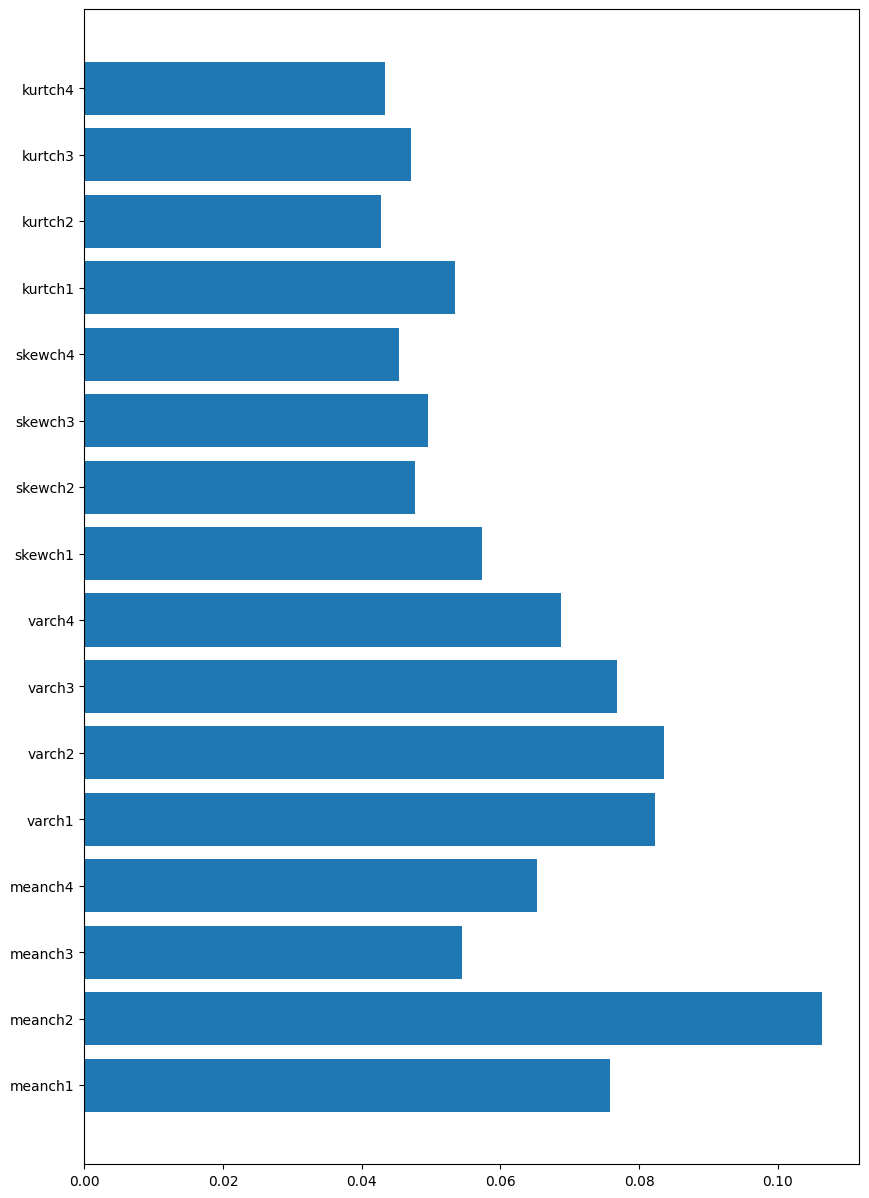

In [ ]:
plt.figure(figsize=(10,15))
y_pos = np.arange(len(X_train.columns))
plt.barh(y_pos, rf.feature_importances_)

# Create names on the y-axis
plt.yticks(y_pos, X_train.columns)
plt.show()

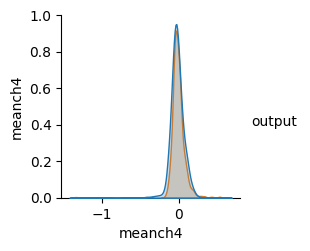

In [ ]:
import seaborn as sns
sns.pairplot(pd.concat((X_train[['meanch4']],y_train),axis=1),hue='output')

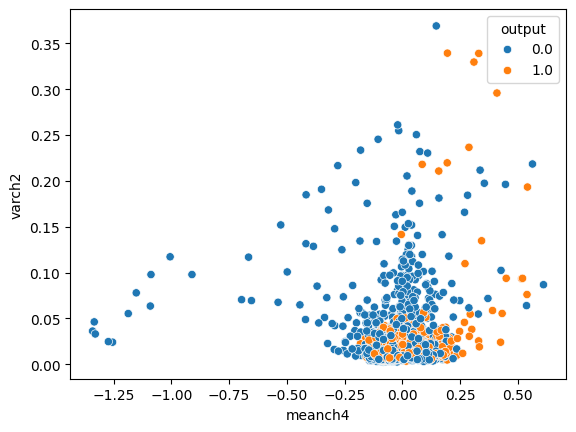

In [ ]:
sns.scatterplot(x='meanch4',y='varch2',hue='output',data=pd.concat((X_train,y_train),axis=1))
plt.show()

Question 11. Based on the plot above, could the variance of channel2 be a good predictor? Why or why not? Could the mean of ch 4 be a good predictor? Why or why not?

In [ ]:
def focal_loss(gamma=4, alpha=0.15):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

# load the dataset, returns train and test X and y elements
def load_dataset(dftrain,dftest):
    trainX = dftrain[:,:-1,:]
    trainy = dftrain[:,-1,0:1]

    testX = dftest[:,:-1,:]
    testy = dftest[:,-1,0:1]

    shuff_idx = np.random.choice(np.arange(0,trainX.shape[0]),trainX.shape[0],replace=False)
    trainX = trainX[shuff_idx,:,:]
    trainy = trainy[shuff_idx]

    shuff_idx = np.random.choice(np.arange(0,testX.shape[0]),testX.shape[0],replace=False)
    testX = testX[shuff_idx,:,:]
    testy = testy[shuff_idx]

    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 200, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    er = EarlyStopping(patience=10, min_delta=1e-4, monitor='val_accuracy')
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,
              validation_split=0.15, callbacks=[er])
    return model

# fit and evaluate a model
def evaluate_model2d(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 20, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    input_layer = Input(shape=(trainX.shape[1], trainX.shape[2], trainX.shape[3]))

    # handle image dimensions ordering
    if tf.keras.backend.image_data_format() == 'channels_first':
        latent = Permute((3, 1, 2))(input_layer)
    else:
        latent = input_layer

    # define the network architecture
    latent = Conv2D(filters=32, kernel_size=(3, 3),
                        activation='relu')(latent)
    latent = Conv2D(filters=64, kernel_size=(3, 3),
                        activation='relu')(latent)
    latent = Dropout(0.5)(latent)
    latent = MaxPooling2D(pool_size=(2, 2))(latent)
    latent = Flatten()(latent)
    latent = Dense(units=100, activation='relu')(latent)
    output_layer = Dense(units=trainy.shape[1], activation='softmax')(latent)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    er = EarlyStopping(patience=10, min_delta=1e-4, monitor='val_accuracy')
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,
              validation_split=0.15, callbacks=[er])
    return model

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment():
    # load data

    trainX, trainy, testX, testy = load_dataset(df_class_train,df_class_test)
    # repeat experiment
    scores = list()

    model = evaluate_model(trainX, trainy, testX, testy)

    ypred = model.predict(testX)
    class_preds = np.argmax(ypred, axis=-1)
    testy = np.argmax(testy,axis=-1)

    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(testy,class_preds))
    return model

In [ ]:
model = run_experiment()

(4061, 50, 4) (4061, 2) (2064, 50, 4) (2064, 2)
Epoch 1/200
108/108 [==============================] - 3s 15ms/step - loss: 0.6337 - accuracy: 0.5949 - val_loss: 0.6141 - val_accuracy: 0.6262
Epoch 2/200
108/108 [==============================] - 1s 10ms/step - loss: 0.5960 - accuracy: 0.6505 - val_loss: 0.5737 - val_accuracy: 0.7049
Epoch 3/200
108/108 [==============================] - 1s 10ms/step - loss: 0.5691 - accuracy: 0.6879 - val_loss: 0.5660 - val_accuracy: 0.7016
Epoch 4/200
108/108 [==============================] - 1s 11ms/step - loss: 0.5434 - accuracy: 0.7065 - val_loss: 0.5286 - val_accuracy: 0.7148
Epoch 5/200
108/108 [==============================] - 1s 10ms/step - loss: 0.4997 - accuracy: 0.7372 - val_loss: 0.5253 - val_accuracy: 0.7443
Epoch 6/200
108/108 [==============================] - 1s 10ms/step - loss: 0.4775 - accuracy: 0.7627 - val_loss: 0.4578 - val_accuracy: 0.7852
Epoch 7/200
108/108 [==============================] - 1s 11ms/step - loss: 0.4223 - acc

Question 12. Compute the 'accuracy' of this model (true positives + true negatives)/ (total). Is this model (CNN) more accurate than the previous models (LogReg, RF, MLP)? Were the manually engineered features better?

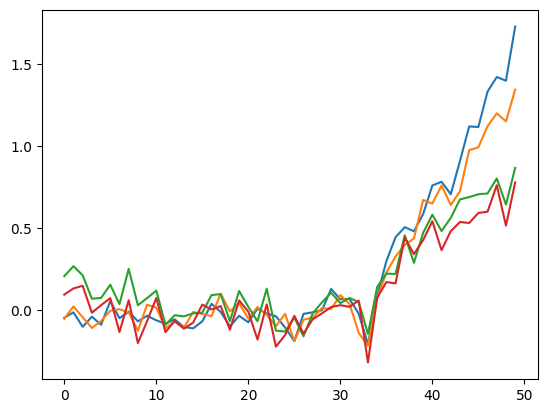

In [ ]:
%matplotlib inline
plt.plot(df_class_test[0,:-1,0])
plt.plot(df_class_test[0,:-1,1])
plt.plot(df_class_test[0,:-1,2])
plt.plot(df_class_test[0,:-1,3])

Question 13. Read & briefly summarize in your own words significant points of information from the following MATLAB EEGLab tutorials: https://eeglab.org/tutorials/

Sections:
5. Preprocess data - a. Filtering
6. Reject artifacts - all sections a-d.
8. Plot data - all sections a-e.

***What did you learn from the EEGLab tutorials about EEG, Filtering, and Artifacts that you did not yet know?***

(Suggested/Optional) Download & use the MATLAB EEGLab on the dataset used in this notebook to try EEGLab yourself and get a better understanding of the tutorials.

Section 5:

Filtering data is important to ensure that both interferance, noise, and undesired data points are omited from the predictin process. This speeds up calculation and reduces error. To do this set up a series of high and low pass frequency filter cut offs, idealy sequentially in steps to reduce accidential data removal.

Section 6:

Rejecting artifacts involves sorting real life data, its not always useful or gathered in a way that is usable. This means getting rid of bad channels, bad data sections, and the implementation of automated sorting algorithims to assist in mass data analysis to save time and memory.

Section 7:

Plotting data is doem by sorting the filtered data into epochs, or ranges of valuable data you want to look at based on 'groundtruth' values from the experiment itslef, this invilves using sub-epochs and estabilshing a base line for the data.

Things I learned:

Well, for a start I learned about the sensitivity of the devices, with electrical signals on circuits we have to moniter the electromagnetic interferance of the component parts. An EEG can pick up signals from powerlines or the lines from the device itself, it also has to sort regular thought interferance as thinking can stimulate the brain in such a way that the data can be skewed.